In [1]:
import xarray as xr 
import os 
import numpy as np 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import os
import cartopy.crs as ccrs


import torch
from torch.utils.data import Dataset
import numpy as np
import xarray as xr
import os
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache
from torch.utils.data import Dataset, DataLoader


import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.nn import Module, ModuleList
from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam

from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from scipy.optimize import linear_sum_assignment

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

from denoising_diffusion_pytorch.attend import Attend

from denoising_diffusion_pytorch.version import __version__
import matplotlib.pyplot as plt

## Gpu

In [2]:
""
gpu_id=0
""
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    
if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB


## Find all the files

In [97]:
fpath_root = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/'

vars = ['PS','PRECT','TREFHT']
bingo = 0
FNS1_big = []
FNS2_big = []
FNS3_big = []
for yryr in range(1850,2020,10):
    for ii in range(1,11):
        for gogo in ['1001','1021','1041','1061','1081','1101','1121','1141','1161','1181']:
            FNS1 = glob.glob(f'{fpath_root}/{vars[0]}/*-{gogo}*.{ii:03}.*{yryr}*')
            FNS2 = glob.glob(f'{fpath_root}/{vars[1]}/*-{gogo}*.{ii:03}.*{yryr}*')
            FNS3 = glob.glob(f'{fpath_root}/{vars[2]}/*-{gogo}*.{ii:03}.*{yryr}*')
            if len(FNS1)>0:
                break
        bingo+=len(FNS1)

        if len(FNS1)>1:
            print('oh no')
        FNS1_big.append(FNS1[0])
        FNS2_big.append(FNS2[0])
        FNS3_big.append(FNS3[0])

In [4]:
dpathO = '/glade/derecho/scratch/wchapman/CESM_LE2_vars/' 
# Check if the directory exists, and if not, create it
if not os.path.exists(dpathO):
    os.makedirs(dpathO)
    print(f"Directory {dpathO} created.")
else:
    print(f"Directory {dpathO} already exists.")
    
for ii in range(len(FNS1_big)):

    f1lis = FNS1_big[ii].split('/')[-1].split(f'{vars[0]}')
    f2lis = FNS2_big[ii].split('/')[-1].split(f'{vars[1]}')
    f3lis = FNS3_big[ii].split('/')[-1].split(f'{vars[2]}')

    out_fil = f'{dpathO}{f1lis[0]}{vars[0]}.{vars[1]}.{vars[2]}{f1lis[1]}'

    if os.path.exists(out_fil):
        print('skipped')
        continue

    DS1 = xr.open_dataset(FNS1_big[ii])
    DS2 = xr.open_dataset(FNS2_big[ii])
    DS3 = xr.open_dataset(FNS3_big[ii])

    if f1lis == f2lis == f3lis:
        DS = xr.merge([DS1,DS2,DS3])[vars]
        DS.to_netcdf(out_fil)
        print(f'made {out_fil}')
    else:
        print('didnt meet criteria')
    





## Get mean and std and max and min

In [243]:
# DSall = xr.open_mfdataset(sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars/*.001.*.nc')))
# DSall.mean().to_array().values

m_1 = []
m_2 = []
m_3 = []
s_1 = []
s_2 = []
s_3 = []
for ii in range(1,11):
    DSall = xr.open_mfdataset(sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars/*.{ii:03}.*.nc')))
    mv = DSall.mean(['time']).to_array().values
    sv = DSall.std(['time']).to_array().values
    m_1.append(mv[0])
    m_2.append(mv[1])
    m_3.append(mv[2])

    s_1.append(sv[0])
    s_2.append(sv[1])
    s_3.append(sv[2])
    print(ii)
    
dicter = {'PS_mean':np.array(m_1).mean(axis=0),'PRECT_mean':np.array(m_2).mean(axis=0),'TREFHT_mean':np.array(m_3).mean(axis=0),
          'PS_std':np.array(s_1).mean(axis=0),'PRECT_std':np.array(s_2).mean(axis=0),'TREFHT_std':np.array(s_3).mean(axis=0)}
# Save to a file
with open('scaling_dict.pkl', 'wb') as file:
    pickle.dump(dicter, file)

1
2
3
4
5
6
7
8
9
10


## Min Max of Scaled Data

In [345]:
# Load from the file

ma_1 = []
ma_2 = []
ma_3 = []
mi_1 = []
mi_2 = []
mi_3 = []

with open('scaling_dict.pkl', 'rb') as file:
    loaded_dicter = pickle.load(file)

for ii in range(1,11):
    print(ii)
    DSall = xr.open_mfdataset(sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars/*.{ii:03}.*.nc')))
    DSall['PS'][:,:,:] = (DSall['PS']-loaded_dicter['PS_mean'])/loaded_dicter['PS_std']

    DSall['PRECT'][:,:,:] = (DSall['PRECT']-loaded_dicter['PRECT_mean'])/loaded_dicter['PRECT_std']

    DSall['TREFHT'][:,:,:] = (DSall['TREFHT']-loaded_dicter['TREFHT_mean'])/loaded_dicter['TREFHT_std']

    ma_1.append(np.max(DSall['PS']).values)
    mi_1.append(np.min(DSall['PS']).values)
    ma_2.append(np.max(DSall['PRECT']).values)
    mi_2.append(np.min(DSall['PRECT']).values)
    ma_3.append(np.max(DSall['TREFHT']).values)
    mi_3.append(np.min(DSall['TREFHT']).values)

dicter = {'PS_max':np.array(ma_1).max(),'PRECT_max':np.array(ma_2).max(),'TREFHT_max':np.array(ma_3).max(),
          'PS_min':np.array(mi_1).min(),'PRECT_min':np.array(mi_2).min(),'TREFHT_min':np.array(mi_3).min()}
# Save to a file
with open('scaling_dict_minmax.pkl', 'wb') as file:
    pickle.dump(dicter, file)

1
2
3
4
5
6
7
8
9
10


## Data set Instance

In [5]:
def get_config():
    config = {
        "input_channels": 1,
        "output_channels": 1,
        "context_image": True,
        "context_channels": 1,
        "num_blocks": [2, 2],
        "hidden_channels": 32,
        "hidden_context_channels": 8,
        "time_embedding_dim": 256,
        "image_size": 128,
        "noise_sampling_coeff": 0.85,
        "denoise_time": 970,
        "activation": "gelu",
        "norm": True,
        "subsample": 100000,
        "save_name": "model_weights.pt",
        "dim_mults": [4, 4],
        "base_dim": 32,
        "timesteps": 1000,
        "pading": "reflect",
        "scaling": "std",
        "optimization": {
            "epochs": 400,
            "lr": 0.01,
            "wd": 0.05,
            "batch_size": 32,
            "scheduler": True
        }
    }
    return config
config = get_config()

In [18]:
class DataProcessed(Dataset):
    def __init__(self, file_paths, config, mean_std_dict, min_max_dict):
        """
        Args:
            file_paths: List of paths to netCDF files
            config: Configuration dict with scaling and augmentation options
        """
        self.file_paths = file_paths
        self.config = config
        self.loaded_mean_std_dict = mean_std_dict
        self.loaded_min_max_dict = min_max_dict
        self.augmentation = config.get('augment', False)
        self.scaler = None
        if config['scaling'] == 'quantile':
            self.scaler = QuantileTransformer()

        # Initialize cache size (you can adjust it depending on memory constraints)
        self.cache_size = config.get('cache_size', 10)
        self.cached_data = {}  # Manual cache for storing loaded data

    def __len__(self):
        # Calculate total number of samples across all files
        total_len = 0
        for path in self.file_paths:
            with xr.open_dataset(path) as ds:
                total_len += ds.sizes['time']  # Assuming 'time' is the main dimension
        return total_len

    def _apply_scaling(self, ds):
        if config['scaling'] == 'std':
            ds['PS'][:,:,:] = (ds['PS'][:,:,:] - self.loaded_mean_std_dict['PS_mean']) / self.loaded_mean_std_dict['PS_std']
            ds['PRECT'][:,:,:] = (ds['PRECT'][:,:,:] - self.loaded_mean_std_dict['PRECT_mean']) / self.loaded_mean_std_dict['PRECT_std']
            ds['TREFHT'][:,:,:] = (ds['TREFHT'][:,:,:] - self.loaded_mean_std_dict['TREFHT_mean']) / self.loaded_mean_std_dict['TREFHT_std']
    
            vars = ['PS','PRECT','TREFHT']
    
            for vv in vars:
                mini = self.loaded_min_max_dict[f'{vv}_min']
                maxi = self.loaded_min_max_dict[f'{vv}_max']
                if maxi > 10:
                    maxi = 10
                if mini <-10:
                    mini = 10
                
                ds[vv][:,:,:] =  (ds[vv][:,:,:] - mini) / (maxi - mini)
            
        else:
            raise ValueError("Invalid scaling method specified.")
    
        return ds

    def _augment_data(self, data):
        # Apply rotations for augmentation
        data_rot90 = np.rot90(data, k=1, axes=(1, 2))
        data_rot180 = np.rot90(data, k=2, axes=(1, 2))
        data_rot270 = np.rot90(data, k=3, axes=(1, 2))
        
        # Concatenate all rotations along the first dimension (time)
        return np.concatenate([data, data_rot90, data_rot180, data_rot270], axis=0)

    @lru_cache(maxsize=4)  # Cache up to 5 file loads at once
    def _load_data_from_file(self, file_path):
        """
        Lazy load the data from file and preprocess it.
        """
        with xr.open_dataset(file_path) as ds:
    
            ds = self._apply_scaling(ds)
                
            data = np.swapaxes(ds.to_array().values,0,1)  # Replace 'forecast' with the relevant key in your dataset
    
            # Apply augmentation if necessary
            if self.augmentation:
                data = self._augment_data(data)
    
        return torch.clamp(torch.tensor(data, dtype=torch.float32),min=0, max=1)

    def __getitem__(self, idx):
        """
        Load data lazily and cache it, based on global index.
        """
        # Determine which file and sample this index belongs to
        cumulative_len = 0
        for file_idx, path in enumerate(self.file_paths):
            with xr.open_dataset(path) as ds:
                file_len = ds.sizes['time']  # Length along the 'time' dimension
                if cumulative_len + file_len > idx:
                    sample_idx = idx - cumulative_len
                    data = self._load_data_from_file(path)  # Load data from cache or disk
                    return data[sample_idx]
                cumulative_len += file_len

        raise IndexError(f"Index {idx} is out of bounds")

## Load this shit

In [19]:
FPs = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars/*.nc'))
config = get_config()
with open('scaling_dict.pkl', 'rb') as file:
    loaded_mean_std_dict = pickle.load(file)

with open('scaling_dict_minmax.pkl', 'rb') as file:
    loaded_min_max_dict = pickle.load(file)

DP =  DataProcessed(FPs, config, loaded_mean_std_dict, loaded_min_max_dict)
DP.__len__()

19800

## Lets add the Climo for each month

In [9]:
for momo in range(1,13):
    for ii in range(1,11):
        print(ii)
        DSall = xr.open_mfdataset(sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars/*.{ii:03}.*.nc')))
        Bingo = DSall['TREFHT']
        Bingo[Bingo['time.month']==momo].values

        #concat these all together on dimension for each month (1-12, and save each one as a netcdf file that has the lat lon info)
        


1


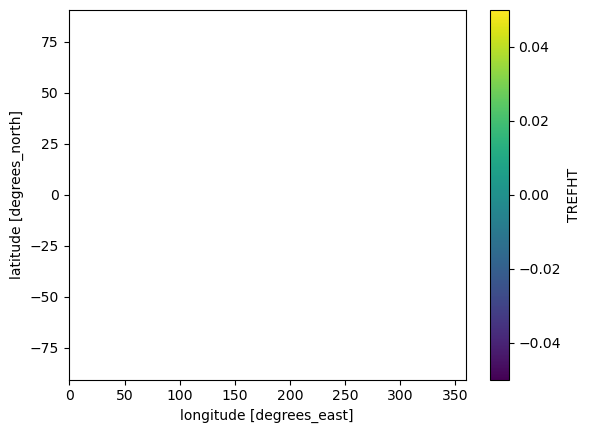

In [92]:
monthly_climo_concat.plot()

In [109]:
import xarray as xr
import glob

# Define the output directory for the climatology files
output_dir = "/glade/derecho/scratch/wchapman/CESM_LE2_vars/CESM_LE2_climo/"

# Loop through each month (1 for January, 2 for February, etc.)
for momo in range(1, 13):
    monthly_climo = []  # List to hold all the data for this month across different ensembles/years
    
    # Loop through the different ensemble members (1 to 10)
    for ii in range(1, 11):
        print(f'{ii} ensemble')
        # Open all the datasets for this ensemble member
        DSall = xr.open_mfdataset(sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars/*.{ii:03}.*.nc')), combine='by_coords')
        
        # Select only the TREFHT data
        Bingo = DSall['TREFHT']

        mdo = momo + 1
        if mdo == 13:
            mdo = 1
        
        # Select only the data for the current month
        monthly_data = Bingo.where(Bingo['time.month'] == mdo, drop=True)
        
        # Append this ensemble member's monthly data to the list
        monthly_climo.append(monthly_data)

    # Concatenate the data along the time dimension
    monthly_climo_concat = xr.concat(monthly_climo, dim='time')
    monthly_climo_concat = monthly_climo_concat.mean('time')
    # Save the concatenated data for this month to a NetCDF file
    output_file = f"{output_dir}climo_month_{momo:02}.nc"
    monthly_climo_concat.to_netcdf(output_file)

    print(f"Saved climatology for month {momo} to {output_file}")


# Define the directory containing the climatology files
climo_dir = output_dir

# List to store all the monthly climatology datasets
monthly_files = sorted(glob.glob(f'{climo_dir}climo_month_*.nc'))

# Open all the monthly climatology files
monthly_datasets = [xr.open_dataset(month) for month in monthly_files]

# Concatenate the monthly datasets along a new 'time' dimension
# We are assuming that each file represents a specific month (1 for Jan, 2 for Feb, etc.)
climo_all_months = xr.concat(monthly_datasets, dim='time')

# Assign the 'time' dimension to represent the 12 months
climo_all_months['time'] = range(1, 13)

# Save the final climatology file with all months
output_file = f"{climo_dir}CESM_LE2_climo_all_months.nc"
climo_all_months.to_netcdf(output_file)

print(f"Saved full climatology file with 12 months to {output_file}")

1 ensemble
2 ensemble
3 ensemble
4 ensemble
5 ensemble
6 ensemble
7 ensemble
8 ensemble
9 ensemble
10 ensemble
Saved climatology for month 1 to /glade/derecho/scratch/wchapman/CESM_LE2_vars/CESM_LE2_climo/climo_month_01.nc
1 ensemble
2 ensemble
3 ensemble
4 ensemble
5 ensemble
6 ensemble
7 ensemble
8 ensemble
9 ensemble
10 ensemble
Saved climatology for month 2 to /glade/derecho/scratch/wchapman/CESM_LE2_vars/CESM_LE2_climo/climo_month_02.nc
1 ensemble
2 ensemble
3 ensemble
4 ensemble
5 ensemble
6 ensemble
7 ensemble
8 ensemble
9 ensemble
10 ensemble
Saved climatology for month 3 to /glade/derecho/scratch/wchapman/CESM_LE2_vars/CESM_LE2_climo/climo_month_03.nc
1 ensemble
2 ensemble
3 ensemble
4 ensemble
5 ensemble
6 ensemble
7 ensemble
8 ensemble
9 ensemble
10 ensemble
Saved climatology for month 4 to /glade/derecho/scratch/wchapman/CESM_LE2_vars/CESM_LE2_climo/climo_month_04.nc
1 ensemble
2 ensemble
3 ensemble
4 ensemble
5 ensemble
6 ensemble
7 ensemble
8 ensemble
9 ensemble
10 ensemb

## Add Climo to each times step in the files... 

In [110]:
output_path = '/glade/derecho/scratch/wchapman/CESM_LE2_vars_with_climo/'
mon_clim = xr.open_dataset('/glade/derecho/scratch/wchapman/CESM_LE2_vars/CESM_LE2_climo/CESM_LE2_climo_all_months.nc')

FPS = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars/*.nc'))

for fp in FPS: 
    print(fp)
    DS  = xr.open_dataset(fp)
    DS['CLIM_T2M'] = xr.zeros_like(DS['TREFHT'])
    for ii in range(len(DS['time'])):
        monget = np.array(DS['time.month'][ii])
        monget = monget -1

        if monget == 0:
            monget = 12
            
        DS['CLIM_T2M'][ii,:,:] = mon_clim.sel(time=monget)['TREFHT'].values
    DS.to_netcdf(output_path+fp.split('/')[-1])

/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.185001-185912.nc
/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.186001-186912.nc
/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.187001-187912.nc
/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.188001-188912.nc
/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.189001-189912.nc
/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.190001-190912.nc
/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.191001-191912.nc
/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.192001-192912.nc
/glade/d

In [114]:
DSd = xr.open_dataset('/glade/derecho/scratch/wchapman/CESM_LE2_vars_with_climo//b.e21.BHISTcmip6.f09_g17.LE2-1181.010.cam.h0.PS.PRECT.TREFHT.199001-199912.nc')

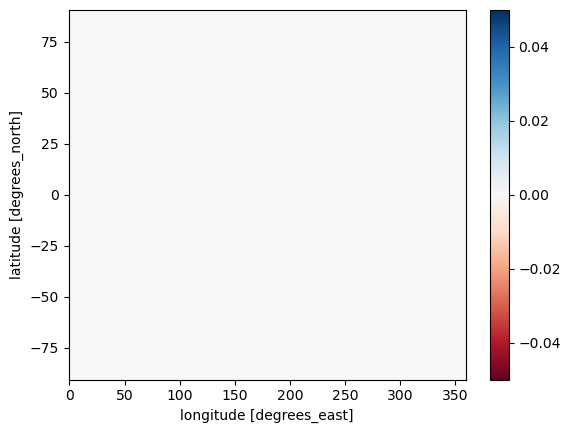

In [126]:
(DSd['CLIM_T2M'].isel(time=11)-climo_all_months.sel(time=12)['TREFHT']).plot(cmap='RdBu')

## Conditional Dataset

In [36]:
class DataProcessed(Dataset):
    def __init__(self, file_paths, config, mean_std_dict, min_max_dict):
        """
        Args:
            file_paths: List of paths to netCDF files
            config: Configuration dict with scaling and augmentation options
        """
        self.file_paths = file_paths
        self.config = config
        self.loaded_mean_std_dict = mean_std_dict
        self.loaded_min_max_dict = min_max_dict
        self.augmentation = config.get('augment', False)
        self.scaler = None
        if config['scaling'] == 'quantile':
            self.scaler = QuantileTransformer()

        # Initialize cache size (you can adjust it depending on memory constraints)
        self.cache_size = config.get('cache_size', 10)
        self.cached_data = {}  # Manual cache for storing loaded data

    def __len__(self):
        # Calculate total number of samples across all files
        total_len = 0
        for path in self.file_paths:
            with xr.open_dataset(path) as ds:
                total_len += ds.sizes['time']  # Assuming 'time' is the main dimension
        return total_len

    def _apply_scaling(self, ds):
        if self.config['scaling'] == 'std':
            ds['PS'][:,:,:] = (ds['PS'][:,:,:] - self.loaded_mean_std_dict['PS_mean']) / self.loaded_mean_std_dict['PS_std']
            ds['PRECT'][:,:,:] = (ds['PRECT'][:,:,:] - self.loaded_mean_std_dict['PRECT_mean']) / self.loaded_mean_std_dict['PRECT_std']
            ds['TREFHT'][:,:,:] = (ds['TREFHT'][:,:,:] - self.loaded_mean_std_dict['TREFHT_mean']) / self.loaded_mean_std_dict['TREFHT_std']
    
            vars = ['PS','PRECT','TREFHT']
    
            for vv in vars:
                mini = self.loaded_min_max_dict[f'{vv}_min']
                maxi = self.loaded_min_max_dict[f'{vv}_max']
                if maxi > 10:
                    maxi = 10
                if mini <-10:
                    mini = 10
                
                ds[vv][:,:,:] =  (ds[vv][:,:,:] - mini) / (maxi - mini)

            ds['CLIM_T2M'][:,:,:] = (ds['CLIM_T2M'][:,:,:] - 211.45393372)/(313.99099731-211.45393372)
            
        else:
            raise ValueError("Invalid scaling method specified.")
    
        return ds

    def _augment_data(self, data):
        # Apply rotations for augmentation
        data_rot90 = np.rot90(data, k=1, axes=(1, 2))
        data_rot180 = np.rot90(data, k=2, axes=(1, 2))
        data_rot270 = np.rot90(data, k=3, axes=(1, 2))
        
        # Concatenate all rotations along the first dimension (time)
        return np.concatenate([data, data_rot90, data_rot180, data_rot270], axis=0)

    @lru_cache(maxsize=2)  # Cache up to 5 file loads at once
    def _load_data_from_file(self, file_path):
        """
        Lazy load the data from file and preprocess it.
        """
        with xr.open_dataset(file_path) as ds:
    
            ds = self._apply_scaling(ds)
            
                
            data = np.swapaxes(ds[['PS','PRECT','TREFHT']].to_array().values,0,1)  # Replace 'forecast' with the relevant key in your dataset
            cond = np.expand_dims(ds['CLIM_T2M'].values,1)  # Replace 'forecast' with the relevant key in your dataset
    
            # Apply augmentation if necessary
            if self.augmentation:
                data = self._augment_data(data)
    
        return torch.clamp(torch.tensor(data, dtype=torch.float32),min=0, max=1), torch.clamp(torch.tensor(cond, dtype=torch.float32),min=0, max=1)

    def __getitem__(self, idx):
        """
        Load data lazily and cache it, based on global index.
        """
        # Determine which file and sample this index belongs to
        cumulative_len = 0
        for file_idx, path in enumerate(self.file_paths):
            with xr.open_dataset(path) as ds:
                file_len = ds.sizes['time']  # Length along the 'time' dimension
                if cumulative_len + file_len > idx:
                    sample_idx = idx - cumulative_len
                    data, cond = self._load_data_from_file(path)  # Load data from cache or disk
                    return data[sample_idx], cond[sample_idx]
                cumulative_len += file_len

        raise IndexError(f"Index {idx} is out of bounds")

In [37]:
FPs = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars_with_climo/*.nc'))
config = get_config()
with open('scaling_dict.pkl', 'rb') as file:
    loaded_mean_std_dict = pickle.load(file)

with open('scaling_dict_minmax.pkl', 'rb') as file:
    loaded_min_max_dict = pickle.load(file)

DP =  DataProcessed(FPs, config, loaded_mean_std_dict, loaded_min_max_dict)
DP.__len__()

19800

In [39]:
dl = DataLoader(DP, batch_size = 4, shuffle = False, pin_memory = True, num_workers = 1)
dd = iter(dl)

In [40]:
vals, conds = next(dd)

In [41]:
vals.shape

torch.Size([4, 3, 192, 288])

In [42]:
conds.shape

torch.Size([4, 1, 192, 288])

In [15]:
'/glade/derecho/scratch/wchapman/CESM_LE2_vars_with_climo/

ls: cannot access '/glade/derecho/scratch/wchapman/CESM_LE2': No such file or directory


In [21]:
DS  = xr.open_dataset('/glade/derecho/scratch/wchapman/CESM_LE2_vars_with_climo/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.191001-191912.nc')

In [35]:
DS['CLIM_T2M'].shape

(120, 192, 288)

In [43]:
import requests
import random

word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
WORDS = response.content.splitlines()

# Generate random indices
rn1 = random.randint(0, len(WORDS) - 1)
rn2 = random.randint(0, len(WORDS) - 1)

# Decode the byte lines to strings
w1 = WORDS[rn1].decode('utf-8')
w2 = WORDS[rn2].decode('utf-8')

print(w1, w2)

elder avoid
